In [1]:
library(tidyverse)
library(gbm) # Generalized Boosted Regression Models

Warning message:
"package 'tidyverse' was built under R version 3.4.3"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 2.2.1     v purrr   0.2.4
v tibble  1.4.1     v dplyr   0.7.4
v tidyr   0.7.2     v stringr 1.2.0
v readr   1.1.1     v forcats 0.2.0
Warning message:
"package 'tibble' was built under R version 3.4.3"Warning message:
"package 'tidyr' was built under R version 3.4.3"Warning message:
"package 'purrr' was built under R version 3.4.3"Warning message:
"package 'dplyr' was built under R version 3.4.2"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'gbm' was built under R version 3.4.3"Loading required package: survival
Loading required package: lattice
Loading required package: splines
Loading required package: parallel
Loaded gbm 2.1.3


## Data

For the data, I collected data on about 6,697 Twitter accounts. I believe 4,243 of those accounts are genuine (non-automated) accounts and 2,454 are bots. I then randomly split the data set into a **training** set and a **test** set. In the training data, I made sure there were equal numbers of bots versus non-bots. Since we are not using the test data to build our actual model, it is not important to have equal group sizes in the test data set.

In [2]:
## read in the data (train and test)
train <- readRDS("datasets/twitter/bot/train.rds")
test <- readRDS("datasets/twitter/bot/test.rds")

In [3]:
t(head(train, 2))

user_id,251344965,17621767
name,Videodisc <U+25B3>,Policy Innovations
screen_name,RolexSound,carnegiePI
location,Barcelona,"New York, NY"
description,I'm not a bot . Music . Drawing . Videogames . Sweet Gig.holo.gram booking dani@divined.com https://t.co/jlLMxj37uD <U+30DA><U+30AC><U+30B5><U+30B9>,Policy Innovations is the @carnegiecouncil magazine for #socialinnovation and global ethics. We talk about doers not bystanders. Follow us on Facebook!
url,https://t.co/QnrvTrhJqP,http://t.co/k2DZ1mSSgt
protected,FALSE,FALSE
followers_count,656,7351
friends_count,2154,2177
listed_count,17,520
statuses_count,2058,12428


In [4]:
t(head(test, 2))

user_id,2311776002,472393931
name,Threat Intelligence,Lucy Bailey
screen_name,threatintelbot,LucyBailey_1989
location,Nepal,
description,All About malware,Proud team member of @TiddlyLink ...If I spent any more time on Twitter they'd probably charge me rent :)
url,NA,https://t.co/2tXLGqIukE
protected,FALSE,FALSE
followers_count,1009,29554
friends_count,28,23252
listed_count,393,137
statuses_count,33590,3535


## How many bots and humans are in each dataset?

In [5]:
## bot == 1, not-bot == 0
table(train_bot = train$bot)

train_bot
   0    1 
1604 1604 

In [6]:
## bot == 1, not-bot == 0
table(test_bot = test$bot)

test_bot
   0    1 
2437  799 

## Define my helper functions

In [7]:
# is this a number?
is_num <- function(x) { 
    return(is.numeric(x) | is.integer(x)) 
}

In [8]:
# example output
print(is_num(100))
print(is_num("hello"))

[1] TRUE
[1] FALSE


In [9]:
# extract features for training

extract_features <- function(data) {
    
    # mutate 6 new features
    
    data %>%
        mutate(
            "bio_chars" = nchar(description),
            "verified" = as.integer(verified),
            "years" = as.integer(difftime(Sys.time(), account_created_at, "days")) / 365,
            "tweets_to_followers" = (statuses_count + 1) / (followers_count + 1),
            "statuses_rate" = statuses_count / years,
            "ff_ratio" = (followers_count + 1) / (friends_count + followers_count + 1),
            'fav_rate' = favourites_count / years,
            'protected' = as.integer(protected),
            'list_rate' = listed_count / years
        ) %>%
        select_if(is_num)
}

In [10]:
# example output
extract_features(head(train))

protected,followers_count,friends_count,listed_count,statuses_count,favourites_count,verified,bot,bio_chars,years,tweets_to_followers,statuses_rate,ff_ratio,fav_rate,list_rate
0,656,2154,17,2058,2832,0,1,120,7.027397,3.133942,292.8538,0.2337247,402.994152,2.4191033
0,7351,2177,520,12428,610,0,1,151,9.243836,1.690560,1344.4635,0.7715395,65.989923,56.2537048
0,260,462,11,1449,420,0,1,137,10.756164,5.555556,134.7134,0.3609959,39.047376,1.0226694
0,329,548,1,50098,46056,0,1,0,1.287671,151.815152,38905.8936,0.3758542,35766.893617,0.7765957
0,617,5,31,5491,30,0,1,160,3.852055,8.886731,1425.4730,0.9919743,7.788051,8.0476529
0,236,217,47,25066,0,0,1,88,8.350685,105.767932,3001.6699,0.5220264,0.000000,5.6282808


In [11]:
ftrain <- extract_features(train)
ftest <- extract_features(test)

## Merge datasets

In [12]:
bind_rows(ftrain, ftest) %>%
    group_by(bot) %>%
    summarize_if(is_num, median, na.rm = TRUE)

# combine the dataset then find the median of all numeric columns grouped by bot or not.

bot,protected,followers_count,friends_count,listed_count,statuses_count,favourites_count,verified,bio_chars,years,tweets_to_followers,statuses_rate,ff_ratio,fav_rate,list_rate
0,0,1497,338,24,21596,6406,0,67,5.605479,11.811940,4906.197,0.7878366,1359.83906,5.560392
1,0,857,249,21,5491,94,0,97,3.994521,8.531579,1499.801,0.6463078,28.57651,5.983607


## Train the model

In [13]:
# Generalized Boosted Regression Models

n_trees <- 500

m1 <- gbm(bot ~ ., 
             data = ftrain,
             n.trees = n_trees,
             interaction.depth = 4, 
             cv.folds = 2,
             verbose = FALSE,
             distribution = "bernoulli",
             n.minobsinnode = 10,
             shrinkage = 0.025)

Warning message in gbm.fit(x, y, offset = offset, distribution = distribution, w = w, :
"variable 1: protected has no variation."

,var,rel.inf
ff_ratio,ff_ratio,32.799557
friends_count,friends_count,23.784207
favourites_count,favourites_count,19.717815
statuses_rate,statuses_rate,4.961784
list_rate,list_rate,2.934025
followers_count,followers_count,2.666080
listed_count,listed_count,2.442595
tweets_to_followers,tweets_to_followers,2.330693
bio_chars,bio_chars,1.913782
statuses_count,statuses_count,1.860418


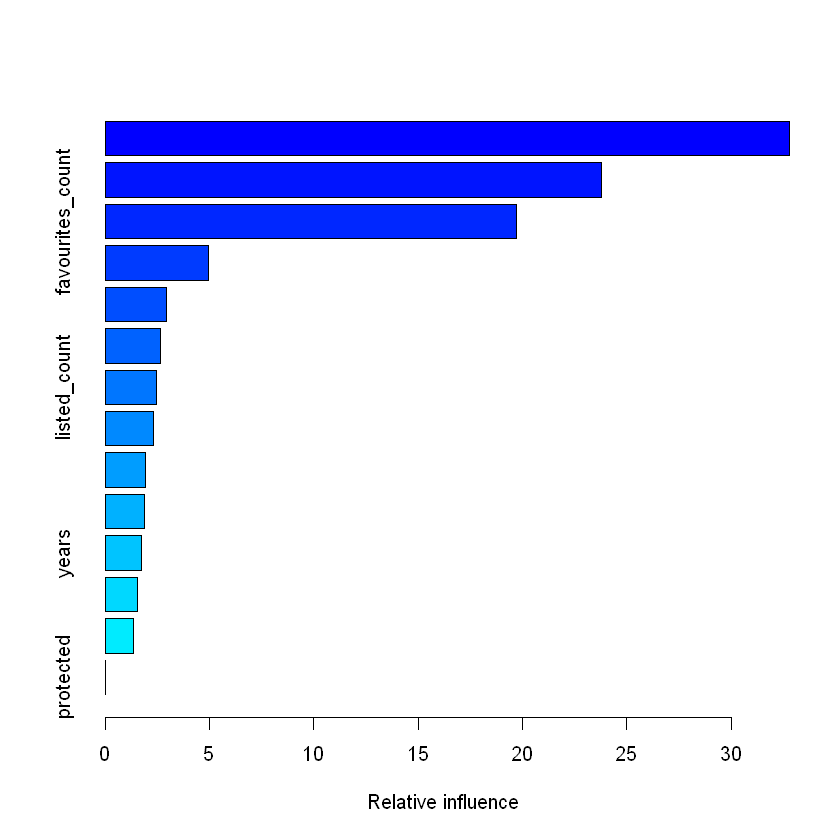

In [14]:
summary(m1, plotit = TRUE)

## Test the model against the training data

In [15]:
ftrain$pred <- predict(m1, n.trees = n_trees, type = "response")

ftrain$pred[0:10]

[1] 0.9194405 0.6450318 0.8329279 0.8580506 0.9775500 0.9355384 0.9777537
 [8] 0.7568239 0.1217069 0.9920777

In [16]:
percent_correct <- function(x) {
    
    # create a 2x2 table of PredictBot and BOT. 
    # CORRECT is defined as pred > 0.5
    x <- table(PredictBot = x$pred > 0.5, bot = x$bot)
    print(x)
    
    print("------------------------")
    
    pc <- round((x[2, 2]) / sum(x[, 2]), 3)
    print(paste("PREDICT BOT & BOT: ", x[2, 2]))
    print(paste("Sum of BOTS: ", sum(x[, 2])))
    print(paste("Percent Correct:", pc * 100))
    pc <- as.character(pc * 100)
    print(paste("The model was", pc, "% accurate when classifying twitter bots."))
    
    print("------------------------")
    
    pc <- round((x[1, 1]) / sum(x[, 1]), 3)
    print(paste("PREDICT NON-BOT & NON-BOT:", x[1, 1]))
    print(paste("Sum of NON-BOTS:", sum(x[, 1])))
    print(paste("Percent Correct:", pc * 100))    
    pc <- as.character(pc * 100)
    print(paste("The model was", pc, "% accurate when clasifying non-bots."))
    
    print("------------------------")
    
    pc <- round((x[1, 1] + x[2, 2]) / sum(c(x[, 1], x[, 2])), 3)
    print(paste("Accurate Predictions:", (x[1, 1] + x[2, 2])))
    print(paste("All Accounts:", sum(c(x[, 1], x[, 2]))))
    pc <- as.character(pc * 100)
    print(paste("Overall, the model was correct", pc, "% of the time."))
}

In [17]:
percent_correct(ftrain)

          bot
PredictBot    0    1
     FALSE 1490  169
     TRUE   114 1435
[1] "------------------------"
[1] "PREDICT BOT & BOT:  1435"
[1] "Sum of BOTS:  1604"
[1] "Percent Correct: 89.5"
[1] "The model was 89.5 % accurate when classifying twitter bots."
[1] "------------------------"
[1] "PREDICT NON-BOT & NON-BOT: 1490"
[1] "Sum of NON-BOTS: 1604"
[1] "Percent Correct: 92.9"
[1] "The model was 92.9 % accurate when clasifying non-bots."
[1] "------------------------"
[1] "Accurate Predictions: 2925"
[1] "All Accounts: 3208"
[1] "Overall, the model was correct 91.2 % of the time."


## Test against our testing dataset

In [18]:
ftest$pred <- predict(m1, newdata = ftest, n.trees = n_trees, type = "response")

In [19]:
percent_correct(ftest)

          bot
PredictBot    0    1
     FALSE 2168  101
     TRUE   269  698
[1] "------------------------"
[1] "PREDICT BOT & BOT:  698"
[1] "Sum of BOTS:  799"
[1] "Percent Correct: 87.4"
[1] "The model was 87.4 % accurate when classifying twitter bots."
[1] "------------------------"
[1] "PREDICT NON-BOT & NON-BOT: 2168"
[1] "Sum of NON-BOTS: 2437"
[1] "Percent Correct: 89"
[1] "The model was 89 % accurate when clasifying non-bots."
[1] "------------------------"
[1] "Accurate Predictions: 2866"
[1] "All Accounts: 3236"
[1] "Overall, the model was correct 88.6 % of the time."


# Not too shabby